# Try for test case 01 using globcurrent data

## 14 days

## adapted from test05 of GlobCurrent

In [1]:
#%matplotlib inline
from parcels import Field, FieldSet, ParticleSet, JITParticle, plotTrajectoriesFile, AdvectionRK4, ErrorCode
import numpy as np
from datetime import timedelta, datetime

In [2]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import num2date, date2num

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import colors 

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter#

* Case 1: Incident occurred on 10/09/2011, west coast of Denmark, ~40km SW of Ringkobing Fjord. Collision with a fishing vessel. Substance spilt was bunker fuel (IFO), Swedish coast impacted.
    * Approx: 55.791887, 7.696803

In [3]:
data_path_v01 = '/data/oceanparcels/input_data/ESA_WorldOceanCirculation/NorthAtlantic/'
fname_v01 = 'runWOC_NATL_4lb_v1_201109*.nc' #runWOC_NATL_4lb_v1_20110901.nc

In [4]:
outdir =  "/data/oceanparcels/output_data/data_LauraGN/outputs_parcels/WOC/Oil/"

# 4. Checking the outputs:

In [5]:
ds = xr.open_dataset(outdir + "20110910000000-WOC-L4-CURlag-NATL_oil_spill_drift_1H_15m_instantaneous-v1.0-fv1.0.nc")


In [16]:
ds

<xarray.Dataset>
Dimensions:     (obs: 337, traj: 20)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
Attributes:
    feature_type:                  trajectory
    Conventions:                   CF-1.7, ACDD-1.3, ISO 8601
    ncei_template_version:         NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:               2.2.2.dev126+g6dd05b7
    parcels_mesh:                  spherical
    Metadata_Conventions:          Climate and Forecast (CF) 1.7, Attribute C...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         North Atlantic 2D horizontal drift of Oil ...
    summary:                       This dataset contains the positions of vir...
    id:                            WOC-L4-CUReul-TATL-1H
    in

# 4.1 Plotting:

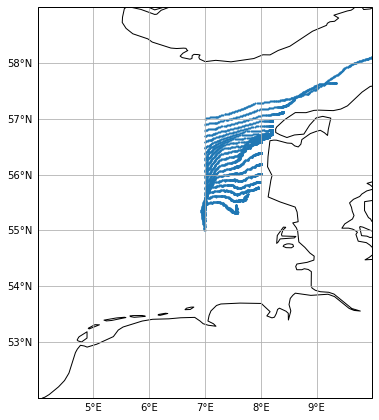

In [17]:
plt.figure(figsize=(6,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(ds['lon'], ds['lat'], s=1, transform=ccrs.PlateCarree()) #marker='o'
ax1.set_xlim([4, 10])
ax1.set_ylim([52, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

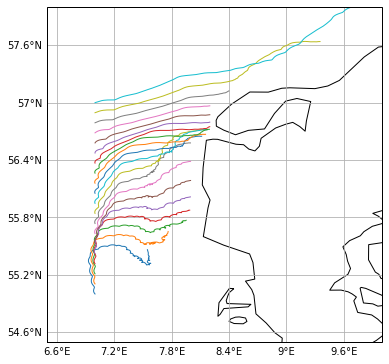

In [18]:
plt.figure(figsize=(6,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.plot(ds['lon'].T, ds['lat'].T, '-', linewidth=1, transform=ccrs.PlateCarree()) #marker='o'
ax1.set_xlim([6.5, 10])
ax1.set_ylim([54.5, 58])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# --> seems to follow bathymetry : https://images.app.goo.gl/6oAd4RHiyZB5Pysa7

### 4.1.1 Plot with velocity data below:

In [7]:
ds_vel = xr.open_mfdataset(data_path_v01 + fname_v01)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


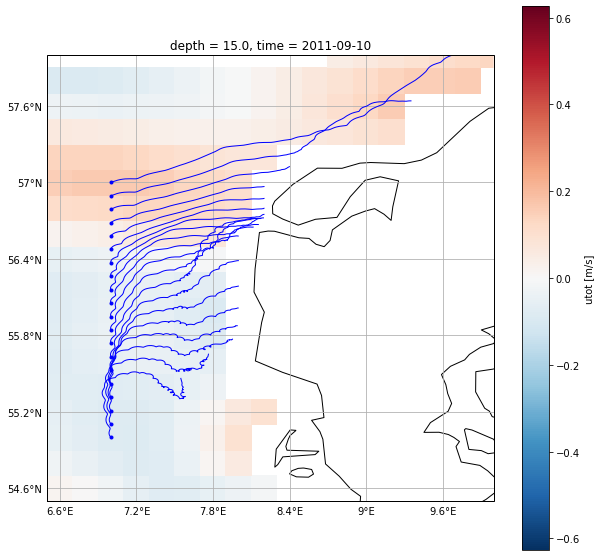

In [20]:
plt.figure(figsize=(10,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')

ds_vel.utot[216,1,:,:].plot(ax=ax1)

ax1.plot(ds['lon'].T, ds['lat'].T, '-b', linewidth=1, transform=ccrs.PlateCarree()) #marker='o'
ax1.plot(ds['lon'][:,0], ds['lat'][:,0], '.b', linewidth=1, transform=ccrs.PlateCarree()) #marker='o'

ax1.set_xlim([6.5, 10])
ax1.set_ylim([54.5, 58])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


# --> particles cross land??

# Masking particles:

In [8]:
ds_vel['mask'] = (('depth', 'lat', 'lon'), ds_vel.utot[0,:,:,:].to_masked_array().mask.astype('int')) 
#ds['nmap'] = (('y', 'x'), nmap)

In [9]:
mask_particles = np.ones_like(ds['lat']) * np.nan

In [ ]:
for tt in range(0, ds['lat'].shape[0]):
    for oo in range(0, ds['lat'].shape[1]):
            if np.isnan(ds['lat'][tt,oo]):
                continue
            else:
                mask_particles[tt,oo] = ds_vel.mask[1,:,:].sel(lat=ds['lat'][tt,oo], lon=ds['lon'][tt,oo], method='nearest')
# vel_mask[1,:,:] as 15m 


In [16]:
mask_particles[:,-1]

array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0.], dtype=float32)

In [18]:
np.where(mask_particles==1.)

(array([ 2,  2,  2, ..., 18, 18, 18]),
 array([253, 254, 255, ..., 334, 335, 336]))

In [19]:
mask_particles.shape

(20, 337)

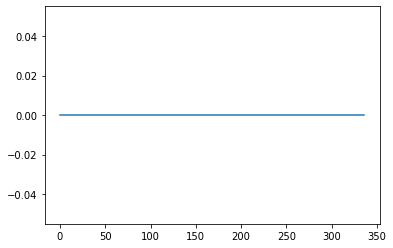

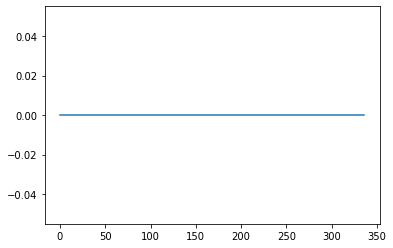

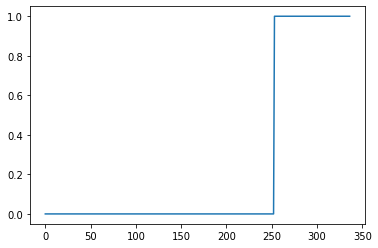

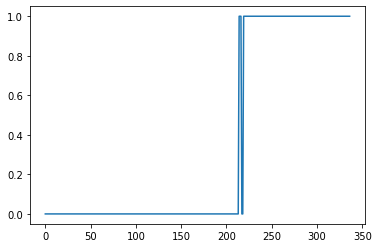

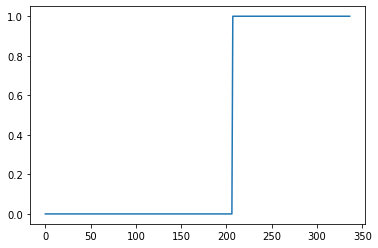

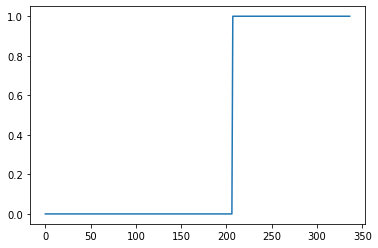

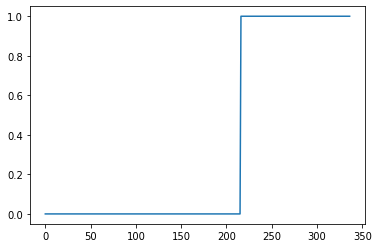

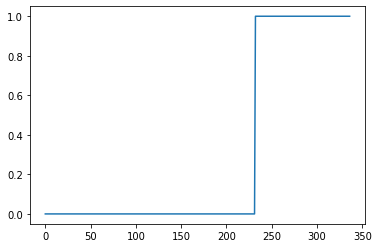

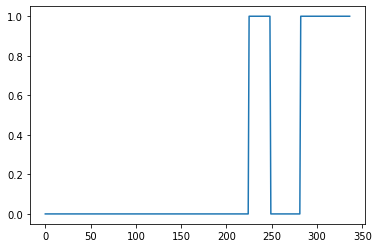

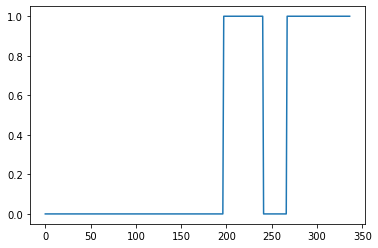

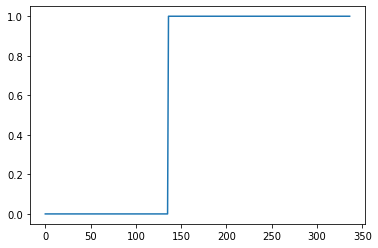

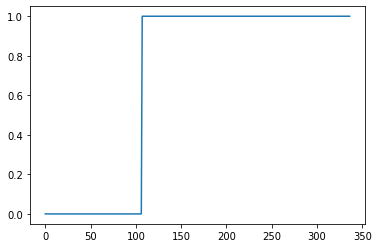

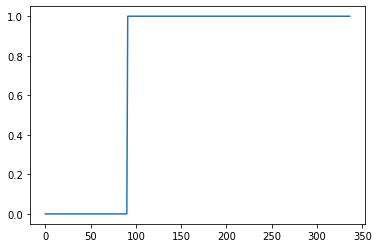

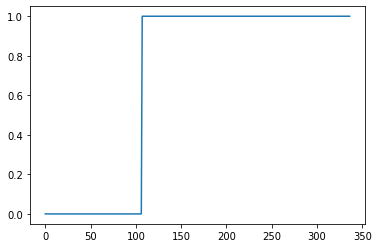

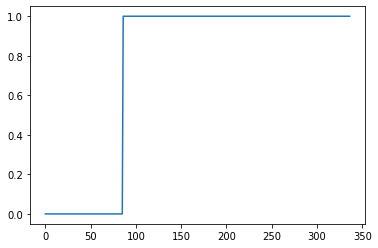

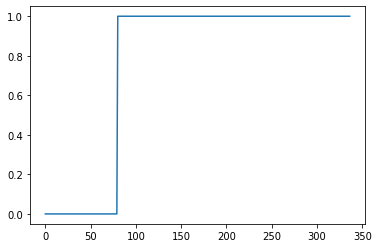

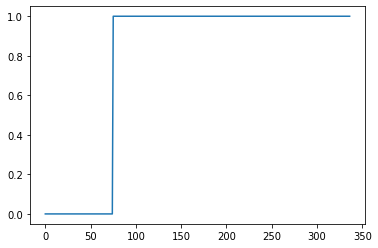

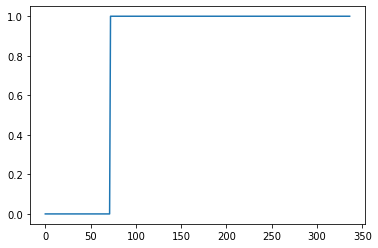

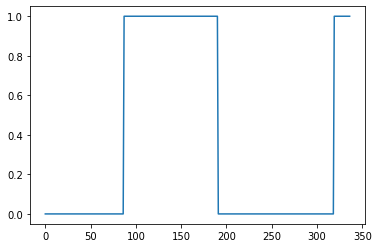

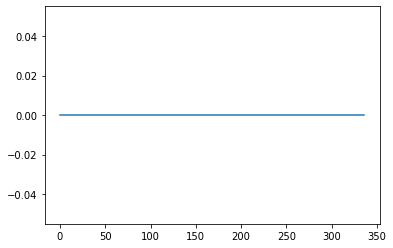

In [20]:
for ii in range (mask_particles.shape[0]):
    plt.figure()
    plt.plot(mask_particles[ii,:])
    plt.show()
    plt.close()

# --> intersting!

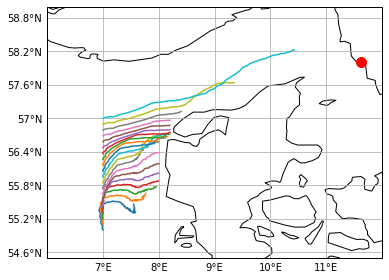

In [34]:
plt.figure(figsize=(6,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')

ax1.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree()) #marker='o'
plt.plot(11.63, 58.01, transform=ccrs.PlateCarree(), marker='o', c='r', markersize=10)
ax1.set_xlim([6, 12])
ax1.set_ylim([54.5, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

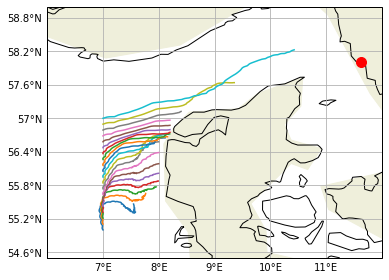

In [35]:
plt.figure(figsize=(6,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.add_feature(cartopy.feature.LAND, facecolor=cartopy.feature.COLORS['land'])

ax1.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree()) #marker='o'
plt.plot(11.63, 58.01, transform=ccrs.PlateCarree(), marker='o', c='r', markersize=10)
ax1.set_xlim([6, 12])
ax1.set_ylim([54.5, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER